# EDA — Part 2: Exposure Density & Sparsity

Examines exposure density and sparsity patterns across H3 cells


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import h3
from shapely.geometry import Polygon
import geopandas as gpd



In [4]:
DATA_PATH = Path('../../dataset/Capstone2025_nsi_lvl9_with_landcover_and_color.csv.gz')
FIGURES_DIR = Path('../../figures/eda')
TABLES_DIR = Path('../../results/tables')

FIGURES_DIR.mkdir(parents=True, exist_ok=True)
TABLES_DIR.mkdir(parents=True, exist_ok=True)

df = pd.read_csv(DATA_PATH, compression='gzip', low_memory=False)
print(f"Dataset shape: {df.shape}")

Dataset shape: (2417766, 8)


### Compute Total Exposure per H3 Cell


In [6]:
exposure_per_h3 = df.groupby('h3').size().reset_index(name='total_exposure')
exposure_per_h3 = exposure_per_h3.sort_values('total_exposure', ascending=False)

print("Exposure per H3 cell summary:")
print(exposure_per_h3['total_exposure'].describe())
print(f"\nMin: {exposure_per_h3['total_exposure'].min()}")
print(f"Max: {exposure_per_h3['total_exposure'].max()}")
print(f"Median: {exposure_per_h3['total_exposure'].median():.1f}")
print(f"Mean: {exposure_per_h3['total_exposure'].mean():.1f}")

display(exposure_per_h3.head(10))


Exposure per H3 cell summary:
count    221108.000000
mean         10.934774
std           7.713547
min           1.000000
25%           3.000000
50%          12.000000
75%          16.000000
max          71.000000
Name: total_exposure, dtype: float64

Min: 1
Max: 71
Median: 12.0
Mean: 10.9


,h3,total_exposure
23568,89283082b53ffff,71
153952,8929a1d75afffff,70
23024,8928308108bffff,69
153927,8929a1d7533ffff,69
23523,89283082a23ffff,68
23041,892830810d7ffff,68
153176,8929a1d62dbffff,67
23432,89283082843ffff,64
153955,8929a1d75bbffff,64
153951,8929a1d75abffff,64


### Examine the Distribution of Exposure (Global)


In [7]:
median_exposure = exposure_per_h3['total_exposure'].median()
pct_below_5 = (exposure_per_h3['total_exposure'] < 5).mean() * 100
pct_below_10 = (exposure_per_h3['total_exposure'] < 10).mean() * 100
pct_below_20 = (exposure_per_h3['total_exposure'] < 20).mean() * 100

print(f"Median exposure: {median_exposure:.1f}")
print(f"% of H3 cells with <5 structures: {pct_below_5:.1f}%")
print(f"% of H3 cells with <10 structures: {pct_below_10:.1f}%")
print(f"% of H3 cells with <20 structures: {pct_below_20:.1f}%")


Median exposure: 12.0
% of H3 cells with <5 structures: 30.5%
% of H3 cells with <10 structures: 44.0%
% of H3 cells with <20 structures: 92.0%


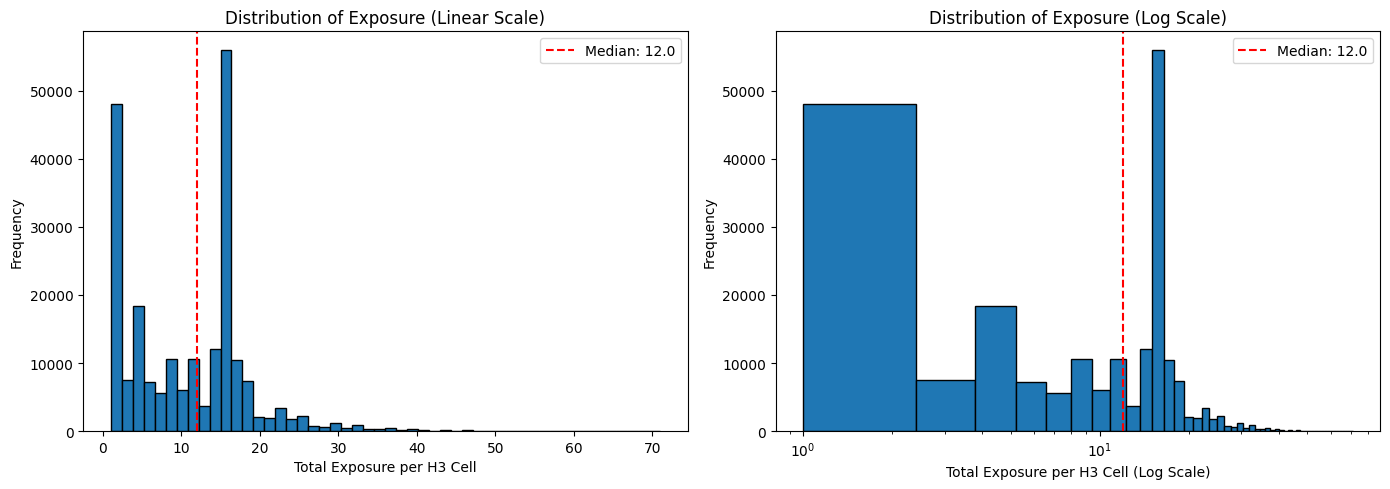

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(exposure_per_h3['total_exposure'], bins=50, edgecolor='black')
axes[0].set_xlabel('Total Exposure per H3 Cell')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Exposure (Linear Scale)')
axes[0].axvline(median_exposure, color='red', linestyle='--', label=f'Median: {median_exposure:.1f}')
axes[0].legend()

axes[1].hist(exposure_per_h3['total_exposure'], bins=50, edgecolor='black')
axes[1].set_xscale('log')
axes[1].set_xlabel('Total Exposure per H3 Cell (Log Scale)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Exposure (Log Scale)')
axes[1].axvline(median_exposure, color='red', linestyle='--', label=f'Median: {median_exposure:.1f}')
axes[1].legend()

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'eda_exposure_distribution.png', dpi=150, bbox_inches='tight')
plt.show()


### Exposure by Landcover Class


In [9]:
h3_landcover_exposure = df.groupby(['h3', 'lc_type']).size().reset_index(name='exposure')
landcover_stats = h3_landcover_exposure.groupby('lc_type')['exposure'].agg([
    'median', 'mean', 'std', 'min', 'max'
]).reset_index()
landcover_stats.columns = ['landcover', 'median_exposure', 'mean_exposure', 'std_exposure', 'min_exposure', 'max_exposure']

landcover_stats['iqr'] = h3_landcover_exposure.groupby('lc_type')['exposure'].apply(
    lambda x: x.quantile(0.75) - x.quantile(0.25)
).values

landcover_stats['pct_low_exposure'] = h3_landcover_exposure.groupby('lc_type')['exposure'].apply(
    lambda x: (x < 10).mean() * 100
).values

landcover_stats = landcover_stats.sort_values('median_exposure', ascending=False)

print("Exposure statistics by landcover class:")
display(landcover_stats)


Exposure statistics by landcover class:


,landcover,median_exposure,mean_exposure,std_exposure,min_exposure,max_exposure,iqr,pct_low_exposure
6,urban,16.0,16.601282,7.056625,1,71,2.0,12.129360
8,urban+crop,16.0,12.259709,6.915828,1,54,10.0,33.480249
10,urban+grass,16.0,14.211894,6.171086,1,53,3.0,19.659725
7,urban+barren,15.0,12.920835,6.899969,1,63,8.0,29.436982
9,urban+forest,13.0,11.744150,5.956771,1,46,9.0,32.006895
12,urban+shrub,13.0,10.738078,6.553090,1,54,11.0,42.348754
11,urban+other,8.0,9.588235,4.861312,3,16,9.0,52.941176
2,forest,4.0,4.965652,3.935015,1,39,5.0,81.887679
3,grass,4.0,5.345036,4.016566,1,29,5.0,84.037301
0,barren,2.0,3.984162,4.203739,1,46,4.0,89.513927


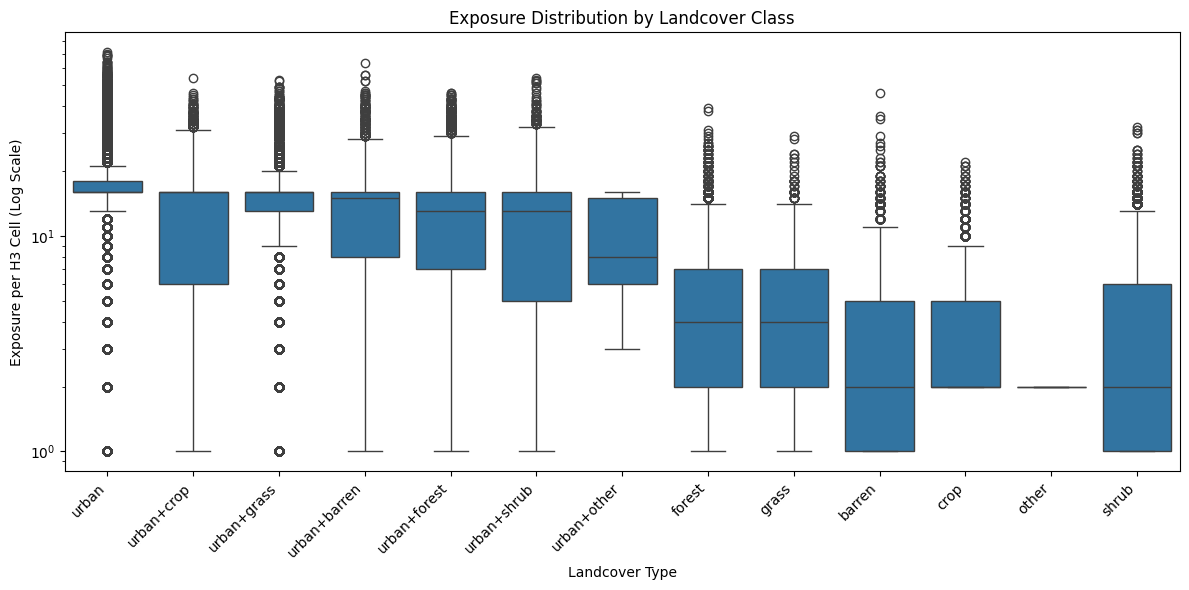

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
landcover_order = landcover_stats.sort_values('median_exposure', ascending=False)['landcover'].values
sns.boxplot(data=h3_landcover_exposure, x='lc_type', y='exposure', order=landcover_order, ax=ax)
ax.set_yscale('log')
ax.set_xlabel('Landcover Type')
ax.set_ylabel('Exposure per H3 Cell (Log Scale)')
ax.set_title('Exposure Distribution by Landcover Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'eda_exposure_by_landcover.png', dpi=150, bbox_inches='tight')
plt.show()


### Exposure by County


In [11]:
county_stats = df.groupby('fips').agg({
    'h3': 'nunique',
    'clr': 'count'
}).reset_index()
county_stats.columns = ['county_fips', 'n_h3_cells', 'total_exposure']

h3_county_exposure = df.groupby(['h3', 'fips']).size().reset_index(name='exposure')
county_medians = h3_county_exposure.groupby('fips')['exposure'].median().reset_index()
county_medians.columns = ['county_fips', 'median_exposure']

county_stats = county_stats.merge(county_medians, on='county_fips')
county_stats = county_stats.sort_values('median_exposure', ascending=False)

print("Exposure statistics by county:")
display(county_stats.head(20))


Exposure statistics by county:


,county_fips,n_h3_cells,total_exposure,median_exposure
37,6075,948,22197,19.0
0,6001,5443,81348,16.0
18,6037,28581,445121,16.0
55,6111,4363,54531,16.0
47,6095,2489,29649,16.0
42,6085,7045,97263,16.0
33,6067,7780,100800,16.0
29,6059,10161,157035,16.0
6,6013,5949,73046,14.0
56,6113,1146,12939,14.0


In [12]:
h3_exposure_map = exposure_per_h3.copy()
h3_exposure_map['log_exposure'] = np.log1p(h3_exposure_map['total_exposure'])

print("Spatial density summary:")
print(f"Exposure ranges from {h3_exposure_map['total_exposure'].min()} to {h3_exposure_map['total_exposure'].max()}")
print(f"Log exposure ranges from {h3_exposure_map['log_exposure'].min():.2f} to {h3_exposure_map['log_exposure'].max():.2f}")
print("\nNote: For full spatial visualization, H3 cells can be mapped using their coordinates.")
print("The exposure distribution shows clear urban-rural contrast patterns.")


Spatial density summary:
Exposure ranges from 1 to 71
Log exposure ranges from 0.69 to 4.28

Note: For full spatial visualization, H3 cells can be mapped using their coordinates.
The exposure distribution shows clear urban-rural contrast patterns.


### Exposure vs Category Diversity


In [13]:
h3_diversity = df.groupby('h3').agg({
    'clr': 'nunique',
    'st_damcat': 'nunique',
    'bldgtype': 'nunique'
}).reset_index()
h3_diversity.columns = ['h3', 'n_colors', 'n_occupancy', 'n_bldgtype']

h3_diversity = h3_diversity.merge(exposure_per_h3, on='h3')

print("Exposure vs category diversity:")
print(f"Correlation (exposure vs n_colors): {h3_diversity['total_exposure'].corr(h3_diversity['n_colors']):.3f}")
print(f"Correlation (exposure vs n_occupancy): {h3_diversity['total_exposure'].corr(h3_diversity['n_occupancy']):.3f}")
print(f"Correlation (exposure vs n_bldgtype): {h3_diversity['total_exposure'].corr(h3_diversity['n_bldgtype']):.3f}")


Exposure vs category diversity:
Correlation (exposure vs n_colors): 0.925
Correlation (exposure vs n_occupancy): 0.465
Correlation (exposure vs n_bldgtype): 0.780


### High-Risk Sparsity Regimes


In [15]:
def categorize_exposure(exposure):
    if exposure < 5:
        return 'Very Low (<5)'
    elif exposure < 10:
        return 'Low (5-9)'
    elif exposure < 20:
        return 'Moderate (10-19)'
    elif exposure < 50:
        return 'Medium (20-49)'
    else:
        return 'High (50+)'

exposure_per_h3['exposure_bin'] = exposure_per_h3['total_exposure'].apply(categorize_exposure)

sparsity_regimes = exposure_per_h3.groupby('exposure_bin').agg({
    'h3': 'count',
    'total_exposure': 'sum'
}).reset_index()
sparsity_regimes.columns = ['exposure_bin', 'n_h3_cells', 'total_structures']

sparsity_regimes['pct_h3_cells'] = (sparsity_regimes['n_h3_cells'] / len(exposure_per_h3) * 100).round(2)
sparsity_regimes['pct_structures'] = (sparsity_regimes['total_structures'] / exposure_per_h3['total_exposure'].sum() * 100).round(2)

bin_order = ['Very Low (<5)', 'Low (5-9)', 'Moderate (10-19)', 'Medium (20-49)', 'High (50+)']
sparsity_regimes['exposure_bin'] = pd.Categorical(sparsity_regimes['exposure_bin'], categories=bin_order, ordered=True)
sparsity_regimes = sparsity_regimes.sort_values('exposure_bin')

print("Sparsity regime analysis:")
display(sparsity_regimes)


Sparsity regime analysis:


,exposure_bin,n_h3_cells,total_structures,pct_h3_cells,pct_structures
4,Very Low (<5),67338,142864,30.45,5.91
1,Low (5-9),29878,203742,13.51,8.43
3,Moderate (10-19),106118,1602487,47.99,66.28
2,Medium (20-49),17650,461846,7.98,19.10
0,High (50+),124,6827,0.06,0.28


In [17]:
exposure_per_h3.to_csv(TABLES_DIR / 'eda_exposure_per_h3.csv', index=False)
landcover_stats.to_csv(TABLES_DIR / 'eda_exposure_by_landcover.csv', index=False)
county_stats.to_csv(TABLES_DIR / 'eda_exposure_by_county.csv', index=False)
sparsity_regimes.to_csv(TABLES_DIR / 'eda_sparsity_regimes.csv', index=False)
h3_diversity.to_csv(TABLES_DIR / 'eda_exposure_diversity.csv', index=False)


In [ ]:
import pandas as pd
import geopandas as gpd
import h3
from shapely.geometry import Polygon

exposure_csv_path = TABLES_DIR / '02_exposure_density_sparsity' / 'eda_exposure_per_h3.csv'
df = pd.read_csv(exposure_csv_path)

def h3_to_polygon(h):
    coords = h3.cell_to_boundary(h)
    return Polygon([(lng, lat) for lat, lng in coords])

print(f"Converting {len(df)} H3 cells to polygons...")
df['geometry'] = df['h3'].apply(h3_to_polygon)

gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')
print(f"Created GeoDataFrame with {len(gdf)} H3 cells")


Converting 221108 H3 cells to polygons...
Created GeoDataFrame with 221108 H3 cells


### Interactive Map (Folium)


In [ ]:
import folium
import numpy as np

bounds = gdf.total_bounds
center_lat = (bounds[1] + bounds[3]) / 2
center_lon = (bounds[0] + bounds[2]) / 2

m = folium.Map(location=[center_lat, center_lon], zoom_start=8, tiles='OpenStreetMap')

def get_color(exposure):
    if exposure < 5:
        return '#ffffcc'
    elif exposure < 10:
        return '#fee391'
    elif exposure < 20:
        return '#fec44f'
    elif exposure < 50:
        return '#fe9929'
    else:
        return '#d73027'

def style_function(feature):
    exposure = feature['properties']['total_exposure']
    return {
        'fillColor': get_color(exposure),
        'color': 'black',
        'weight': 0.1,
        'fillOpacity': 0.7,
    }

folium.GeoJson(
    gdf.to_json(),
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(fields=['h3', 'total_exposure', 'exposure_bin'], aliases=['H3:', 'Exposure:', 'Bin:']),
    popup=folium.GeoJsonPopup(fields=['h3', 'total_exposure', 'exposure_bin'])
).add_to(m)

m


ImportError: The 'folium>=0.12', 'matplotlib' and 'mapclassify' packages are required for 'explore()'. You can install them using 'conda install -c conda-forge "folium>=0.12" matplotlib mapclassify' or 'pip install "folium>=0.12" matplotlib mapclassify'.

### Static Publication-Quality Map (Matplotlib)


In [ ]:
fig, ax = plt.subplots(figsize=(8, 10))
gdf.plot(
    column="total_exposure",
    cmap="viridis",
    linewidth=0,
    ax=ax,
    legend=True
)
ax.set_axis_off()
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'eda_exposure_density_map_static.png', dpi=150, bbox_inches='tight')
plt.show()


In [ ]:
gdf.to_file(FIGURES_DIR / 'eda_exposure_density_map.geojson', driver='GeoJSON')
print(f"Saved GeoJSON file to: {FIGURES_DIR / 'eda_exposure_density_map.geojson'}")
